<a href="https://colab.research.google.com/github/Jojo666/Coursera_Capstone/blob/main/2Singapore_thai_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IBM Capstone Project**

In this project, I will find out the best neighborhood in Singapore for  to open a new Thai Restaurant by:

1.   Using multiple datasets from different sources (i.e. Web, Geocode, CSV files, Foursquare API)
2.   Python Webscraping using Beautifulsoup
3.   Data Preprocessing
4.   Data Analysis

I will obtain the geolocations of the different Planning Areas located within 5 of Singapore's Regions (North, West, Central) and use the Foursquare API to extract the details of venues near the planning areas. My gaols is to look for planning areas with the lowest clustering of Thai resturants (using unsupervised learning) as these planning areas will have the lowest competition for a new Thai resturant

**The Dataset Creation Workflow:** I will scrape the names of the regions and their planning areas from Wikipedia. I will obtain their geolocations using the geopy module. I will obtain the information about the different venues corresponding to the different planning areas using Foursquare's API. I will obtain venue geolocations, names and categories. The final dataset I use for analysis will comprise of: Region, Planning Area, Latitude, Longitude, Venue Name, Venue Latitude, Venue Longitude, Venue Category

Target audience: (a) Those looking to set up a Thai resturant in Singapore (b) People intersted in the resturant business in Sinagpore (c) People intersted in the different social venues in the different parts of Singapore
I am going to focus on Planning Area wscale analysis as each of Singapore's Regions is divided into Planning Areas

In [6]:
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from lxml.html import fromstring 
import re
import csv
import pandas as pd



**Step 1:**
I scraped wikipedia for the list of places in Singapore. I looped through multiple pages to obtain details of the 5 Regions and their associated Planning Areas within Singapore 

In [7]:
wiki = "https://en.wikipedia.org/wiki/List_of_places_in_Singapore"
header = {'User-Agent': 'Mozilla/5.0'}
req = Request(wiki,headers=header)
page = urlopen(req)

soup = BeautifulSoup(page, features="lxml")


def get_remaining_tables():
    global df
    planning_area = []
    subzone = []
    region =[]
    footnotes = []

    ul_ids = {'East': 1, 'North': 7, 'North-East': 14, 'West': 21}
    unorderedLists = soup.find_all('ul')

    for x in ul_ids:
        eastern_region1 = unorderedLists[ul_ids[x]].findChild('li')
        eastern_regions = eastern_region1.find_next_siblings('li')
        eastern_regions.insert(0,eastern_region1)
        for i in eastern_regions:
            kids = i.findChildren('li')
            for j in kids:    
                
                try:
                        if j.find_parent('li').find_previous_sibling('li').findChild('li'):
                            pass
                        else:
                            if j.find_parent('li').find_previous_sibling('li').findChild('a').text not in planning_area:
                                planning_area.append(j.find_parent('li').find_previous_sibling('li').findChild('a').text)
                                subzone.append(j.find_parent('li').find_previous_sibling('li').findChild('a').text)
                                region.append(x)
                                footnotes.append('')
              
                        if j.find_parent('li').find_previous_sibling('li').find_previous_sibling('li').findChild('li'):
                            pass
                        else:
                            if j.find_parent('li').find_previous_sibling('li').find_previous_sibling('li').findChild('a').text not in planning_area:
                                planning_area.append(j.find_parent('li').find_previous_sibling('li').find_previous_sibling('li').findChild('a').text)
                                subzone.append(j.find_parent('li').find_previous_sibling('li').find_previous_sibling('li').findChild('a').text)
                                region.append(x)
                                footnotes.append('')
                except:
                      pass
                planning_area.append(j.find_parent('li').find('a').text)
                subzone_string = str(j.text)
                try:
                    if subzone_string.index('('):
                        parsed_subzone = subzone_string.index('(')
                        footnotes.append(subzone_string[int(parsed_subzone):])
                        subzone.append(subzone_string[:int(parsed_subzone)])
                       
                except:
                    footnotes.append('')
                    subzone.append(subzone_string)
                region.append(x)

    planning_area.append('Western Water Catchment')
    subzone.append('Western Water Catchment')
    region.append('West')
    footnotes.append('')
    
    df = pd.DataFrame(list(zip(region, planning_area, subzone, footnotes)), columns = list(['Region', 'Planning Area', 'Subzone', 'Footnotes']))



def get_central_table():
    global df2
    master_list = []
    header_list = []
    table = soup.find_all('table')[1]
    headers = table.find_all('th')
    for header in headers:
        header_list.append(header.text)
    rows = table.find_all('tr')
    for row in rows[1:]:
        row_data = []
        row_length = len(row.find_all('td'))
        if row_length ==2:
            planning_area = False
        elif row_length ==3:
            planning_area = True
        if planning_area:
           planning_area_raw = row.findChild('td').text.strip()
           index_bracket = planning_area_raw.index('[')
           planning_area_text = planning_area_raw[:int(index_bracket)]
           subzone_text = row.findChild('td').find_next_sibling('td').text.strip()
           footnote_text = row.findChild('td').find_next_sibling('td').find_next_sibling('td').text.strip()
           row_data.append(planning_area_text)
           row_data.append(subzone_text)
           row_data.append(footnote_text)
           master_list.append(row_data)
        else:
           planning_area_text = ''
           subzone_text = row.findChild('td').text.strip()
           try:
                footnote_text = row.findChild('td').find_next_sibling('td').text.strip()
           except:
                footnote_text = ''
           row_data.append(planning_area_text)
           row_data.append(subzone_text)
           row_data.append(footnote_text)
           master_list.append(row_data)
    for a in range(len(master_list)):
        if master_list[a][0] == '':
            master_list[a][0] = master_list[a-1][0]
    for b in range(len(master_list)):
        master_list[b].insert(0,'Central')
    df2 = pd.DataFrame(data = master_list, columns = list(['Region', 'Planning Area', 'Subzone', 'Footnotes']))
    


    


get_central_table()
get_remaining_tables()

df3 = df2.append(df, ignore_index=True)
#df3.to_excel('Test.xlsx', index=False)
df3.to_pickle('Subzone Dataframe.pkl')

# Parse List for Dataframe of Planning Areas
df4 = df3
df4.drop_duplicates(subset ='Planning Area', keep="first", inplace=True, ignore_index=True)
df4.drop('Subzone', axis=1, inplace=True)
df4.drop('Footnotes', axis=1, inplace=True)
df4.to_pickle('Planning Area Dataframe.pkl')

The data obtained comprises of: Region and Planning Area. 
We can also scrape the data for the sub-zones present in the planning area for a finer scale analysis. However for this analysis, my unit of analysis is the planning area as this infomration is consistently avlaible for all 5 of Singapore's regions

In [8]:
df3

,Region,Planning Area
0,Central,Bishan
1,Central,Bukit Merah
2,Central,Bukit Timah
3,Central,Downtown Core
4,Central,Geylang
5,Central,Kallang
6,Central,Marina East
7,Central,Marina South
8,Central,Marine Parade
9,Central,Museum


In [9]:
dfx = df3.rename({'Planning Area': 'Area'}, axis=1) 

In [10]:
dfx.head()

,Region,Area
0,Central,Bishan
1,Central,Bukit Merah
2,Central,Bukit Timah
3,Central,Downtown Core
4,Central,Geylang


**Step 2**
Geocoding Singapore's Planning Areas using geopy

In [11]:
!pip install geopandas
!pip install geopy

     |████████████████████████████████| 1.0MB 5.1MB/s 
     |████████████████████████████████| 15.3MB 249kB/s 
     |████████████████████████████████| 6.5MB 51.2MB/s 


In [12]:
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and lo

In [13]:
locator = Nominatim(user_agent='myGeocoder')


In [14]:
from geopy.extra.rate_limiter import RateLimiter

# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
dfx['location'] = dfx['Area'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
dfx['point'] = dfx['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
dfx[['latitude', 'longitude', 'altitude']] = pd.DataFrame(dfx['point'].tolist(), index=dfx.index)

In [ ]:
dfx.head()

,Region,Area,location,point,latitude,longitude,altitude
0,Central,Bishan,"(Bishan, Bishan Place, Bishan, Singapore, Cent...","(1.3509859, 103.84825507492937, 0.0)",1.350986,103.848255,0.0
1,Central,Bukit Merah,"(Bukit Merah, Padang Terap, Kedah, Malaysia, (...","(6.2102098, 100.7640922, 0.0)",6.210210,100.764092,0.0
2,Central,Bukit Timah,"(Bukit Timah Hill, Northwest, 589333, Singapor...","(1.3546901, 103.7763724, 0.0)",1.354690,103.776372,0.0
3,Central,Downtown Core,"(Downtown Core, Singapore, Central, Singapore,...","(1.28747505, 103.85603322292744, 0.0)",1.287475,103.856033,0.0
4,Central,Geylang,"(Geylang, Southeast, Singapore, (1.3181862, 10...","(1.3181862, 103.8870563, 0.0)",1.318186,103.887056,0.0


In [15]:
dfx.drop(['location', 'point','altitude'], axis='columns', inplace=True)

In [16]:
dfx.head(n=6)

,Region,Area,latitude,longitude
0,Central,Bishan,1.350986,103.848255
1,Central,Bukit Merah,4.561694,101.024037
2,Central,Bukit Timah,1.354690,103.776372
3,Central,Downtown Core,1.287475,103.856033
4,Central,Geylang,1.318186,103.887056
5,Central,Kallang,1.310759,103.866262


'dfx' dataframe contains the details of Singapore's Regions, Planning Areas and the latitudes and longitudes of the latter

Which of Singapore's planning regions has the maximum neighbourhoods

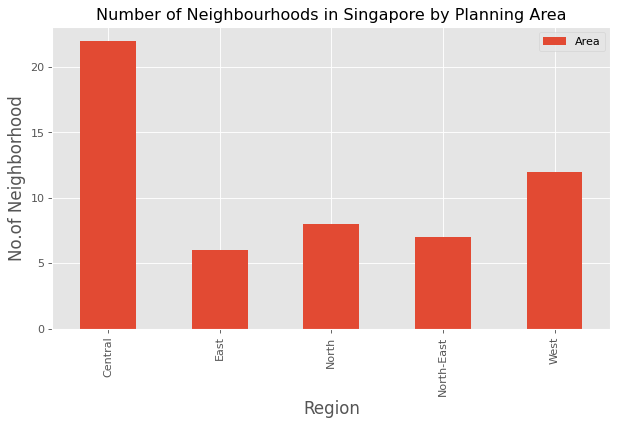

In [17]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhoods in Singapore by Planning Area')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
dfx.groupby('Region')['Area'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
#dfx.to_csv('/content/drive/MyDrive/IBM/singapore_geo1.csv')

In [18]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation


!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


! pip install folium==0.5.0
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

     |████████████████████████████████| 81kB 3.2MB/s 
  Created wheel for folium: filename=folium-0.5.0-cp37-none-any.whl size=76240 sha256=466b7012c3effc6c3d84aae3b1da137300bfc9c420ebdb58514c5a6961d80b9f
  Stored in directory: /root/.cache/pip/wheels/f8/98/ff/954791afc47740d554f0d9e5885fa09dd60c2265d42578e665
Successfully built folium
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.5.0 which is incompatible.
  Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
Folium installed
Libraries imported.


**Step 3**
Obtain the data of different ventues from Foursquare's API

In [19]:
CLIENT_ID = '2F1CJNJUWG2YWCD4UCXMQ4UJ4YB3K21Z4AIAHWRXJX02EJY2' # your Foursquare ID
CLIENT_SECRET = 'A24ALYYVZVBLHWB2C52MEU5GXPVFMGT40HF1C30K1J3DYSL0' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2F1CJNJUWG2YWCD4UCXMQ4UJ4YB3K21Z4AIAHWRXJX02EJY2
CLIENT_SECRET:A24ALYYVZVBLHWB2C52MEU5GXPVFMGT40HF1C30K1J3DYSL0


In [ ]:
## Singapore's lat-longs and venues

In [20]:
address = 'Singapore'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

1.357107 103.8194992


Obtain venues corresponding to the lat-long locations from the Foursquare API

We will obtain the following infomration about the Venues: (a) Venue lat long (b) venue category (c) venue name

Other data that we can obtain from the Foursquare API include: (a) reviews (b) menus. However I will not focus on these

In [ ]:
radius = 5000
LIMIT = 100

def getVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue_Lat', 
                  'Venue_Long', 
                  'Venue_Category']
    
    return(nearby_venues)

In [ ]:
dfx.head(n=3)

,Region,Area,latitude,longitude
0,Central,Bishan,1.350986,103.848255
1,Central,Bukit Merah,6.210210,100.764092
2,Central,Bukit Timah,1.354690,103.776372


In [ ]:
Singapore_Venues = getVenues(names=dfx['Area'],
                        latitudes=dfx['latitude'],
                        longitudes=dfx['longitude'])

Bishan
Bukit Merah
Bukit Timah
Downtown Core
Geylang
Kallang
Marina East
Marina South
Marine Parade
Museum
Newton
Novena
Orchard
Outram
Queenstown
River Valley
Rochor
Singapore River
Southern Islands
Straits View
Tanglin
Toa Payoh
Bedok
Changi
Changi Bay
Pasir Ris
Paya Lebar
Tampines
Lim Chu Kang
Central Water Catchment
Mandai
Sembawang
Simpang
Sungei Kadut
Woodlands
Yishun
Ang Mo Kio
Hougang
North-Eastern Islands
Punggol
Seletar
Sengkang
Serangoon
Boon Lay
Bukit Batok
Bukit Panjang
Choa Chu Kang
Clementi
Jurong East
Jurong West
Pioneer
Tengah
Tuas
Western Islands
Western Water Catchment


In [24]:
Singapore_Venues.head()

,Borough,Latitude,Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
0,Bishan,1.350986,103.848255,Bishan - Ang Mo Kio Park,1.362219,103.846250,Park
1,Bishan,1.350986,103.848255,Tori-Q,1.350549,103.848659,Japanese Restaurant
2,Bishan,1.350986,103.848255,Aramsa ~ The Garden Spa,1.362292,103.847602,Spa
3,Bishan,1.350986,103.848255,Sin Ming Roti Prata (Faisal & Aziz Curry Musli...,1.355269,103.836719,Indian Restaurant
4,Bishan,1.350986,103.848255,Chocolat N' Spice,1.351867,103.837558,Bakery


In [25]:
Singapore_Venues = Singapore_Venues.rename({'Borough': 'Area'}, axis=1) 

Venue Distribution Across Singapore

In [26]:
pd.crosstab(index=Singapore_Venues['Venue_Category'], columns=Singapore_Venues['Area'])

Area,Ang Mo Kio,Bedok,Bishan,Boon Lay,Bukit Batok,Bukit Merah,Bukit Panjang,Bukit Timah,Central Water Catchment,Changi Bay,Choa Chu Kang,Clementi,Downtown Core,Geylang,Hougang,Jurong East,Jurong West,Kallang,Lim Chu Kang,Mandai,Marina East,Marina South,Marine Parade,Museum,Newton,North-Eastern Islands,Novena,Orchard,Outram,Pasir Ris,Paya Lebar,Punggol,Queenstown,River Valley,Rochor,Seletar,Sembawang,Sengkang,Serangoon,Simpang,Singapore River,Southern Islands,Straits View,Sungei Kadut,Tampines,Tanglin,Tengah,Toa Payoh,Tuas,Western Water Catchment,Woodlands,Yishun
Venue_Category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Accessories Store,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Airport,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
Airport Food Court,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Airport Lounge,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
Airport Service,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wings Joint,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
Yoga Studio,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,2,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,3,0,0,0,0,0,0
Yunnan Restaurant,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Which are the most common social avenues in Singapore?

In [27]:
Singapore_Venues_unique_count = Singapore_Venues['Venue_Category'].value_counts().to_frame(name='Count')
Singapore_Venues_unique_count.head()

,Count
Hotel,194
Chinese Restaurant,188
Coffee Shop,174
Park,149
Café,125


In [28]:
import matplotlib.cm as cm
import matplotlib.colors as colors
print('matplotlib imported...')
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

matplotlib imported...


Where are the most common venues located?

In [29]:
hotel=Singapore_Venues[Singapore_Venues.Venue_Category == 'Hotel']
for lat, lon, poi in zip(hotel['Venue_Lat'], hotel['Venue_Long'], hotel['Area']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        
        fill=True,
        
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
chin=Singapore_Venues[Singapore_Venues.Venue_Category == 'Chinese Restaurant']
for lat, lon, poi in zip(chin['Venue_Lat'], chin['Venue_Long'], chin['Area']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        
        fill=True,
        
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
cf=Singapore_Venues[Singapore_Venues.Venue_Category == 'Coffee Shop']
for lat, lon, poi in zip(cf['Venue_Lat'], cf['Venue_Long'], cf['Area']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        
        fill=True,
        
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

While hotels are concentrated at one location, Chinese resturants and Coffee Shops are numerous and well-distributed. Hence for someone wishing to enter the resturant business, other cuisne resturants such as Thai resturants might be better.

In [30]:
# one hot encoding
singapore_onehot = pd.get_dummies(Singapore_Venues[['Venue_Category']], prefix = "", prefix_sep = "")

In [31]:
# add neighborhood column back to dataframe
singapore_onehot['Area'] = Singapore_Venues['Area']

In [32]:
# move neighborhood column to the first column
fixed_columns = [singapore_onehot.columns[-1]] + list(singapore_onehot.columns[:-1])
singapore_onehot = singapore_onehot[fixed_columns]
singapore_onehot.head()

,Area,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Bay,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,...,Sports Bar,Stables,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Travel Lounge,Tree,Urgent Care Center,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Yunnan Restaurant,Zoo,Zoo Exhibit
0,Bishan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bishan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bishan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bishan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bishan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


What are the Most Common Venues By Area?

In [33]:
Brgh_grouped = singapore_onehot.groupby('Area').mean().reset_index()
Brgh_grouped.head(n=3)

,Area,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Bay,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,...,Sports Bar,Stables,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Travel Lounge,Tree,Urgent Care Center,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Yunnan Restaurant,Zoo,Zoo Exhibit
0,Ang Mo Kio,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.02,0.0,0.01,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.02,0.01,...,0.00,0.0,0.01,0.0,0.0,0.02,0.01,0.01,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.00,0.00,0.0,0.0,0.0
1,Bedok,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.00,0.0,0.04,0.00,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.01,...,0.01,0.0,0.00,0.0,0.0,0.02,0.00,0.00,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.01,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.01,0.01,0.0,0.0,0.0
2,Bishan,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.02,0.0,0.04,0.02,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.01,...,0.00,0.0,0.01,0.0,0.0,0.05,0.01,0.01,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.00,0.00,0.0,0.0,0.0


In [34]:
num_top_venues = 5

for brgh in Brgh_grouped['Area']:
    print("_________"+brgh+"________")
    temp = Brgh_grouped[Brgh_grouped['Area'] == brgh].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

_________Ang Mo Kio________
                venue  freq
0  Chinese Restaurant  0.11
1     Thai Restaurant  0.06
2         Coffee Shop  0.06
3                Park  0.06
4          Food Court  0.04


_________Bedok________
                venue  freq
0  Chinese Restaurant  0.10
1         Coffee Shop  0.09
2        Dessert Shop  0.05
3    Asian Restaurant  0.05
4                Café  0.04


_________Bishan________
                venue  freq
0  Chinese Restaurant  0.09
1          Food Court  0.06
2                Park  0.06
3         Supermarket  0.05
4              Bakery  0.04


_________Boon Lay________
                  venue  freq
0    Chinese Restaurant  0.12
1            Food Court  0.06
2           Coffee Shop  0.05
3  Fast Food Restaurant  0.04
4   Japanese Restaurant  0.04


_________Bukit Batok________
                 venue  freq
0   Chinese Restaurant  0.07
1  Japanese Restaurant  0.04
2   Italian Restaurant  0.04
3    Indian Restaurant  0.04
4               Bakery  0.04


__

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
brgh_venues_sorted = pd.DataFrame(columns=columns)
brgh_venues_sorted['Area'] = Brgh_grouped['Area']

for ind in np.arange(Brgh_grouped.shape[0]):
    brgh_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Brgh_grouped.iloc[ind, :], num_top_venues)

brgh_venues_sorted.head(8)

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ang Mo Kio,Chinese Restaurant,Coffee Shop,Thai Restaurant,Park,Café
1,Bedok,Chinese Restaurant,Coffee Shop,Dessert Shop,Asian Restaurant,Beach
2,Bishan,Chinese Restaurant,Park,Food Court,Supermarket,Bakery
3,Boon Lay,Chinese Restaurant,Food Court,Coffee Shop,Japanese Restaurant,Fast Food Restaurant
4,Bukit Batok,Chinese Restaurant,Indian Restaurant,Bakery,Japanese Restaurant,Italian Restaurant
5,Bukit Merah,Chinese Restaurant,Malay Restaurant,Convenience Store,Seafood Restaurant,Asian Restaurant
6,Bukit Panjang,Zoo Exhibit,Park,Coffee Shop,Nature Preserve,Supermarket
7,Bukit Timah,Italian Restaurant,Chinese Restaurant,Bakery,Park,Nature Preserve


k-means clustering to identify the spatial distribution of Thai resturants


In [40]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.metrics import silhouette_samples, silhouette_score

In [37]:
thai = Brgh_grouped[["Area","Thai Restaurant"]]
thai.head() #.head() shows the first five rows only

,Area,Thai Restaurant
0,Ang Mo Kio,0.06
1,Bedok,0.03
2,Bishan,0.03
3,Boon Lay,0.01
4,Bukit Batok,0.02


decide on the optimal number of clusters

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


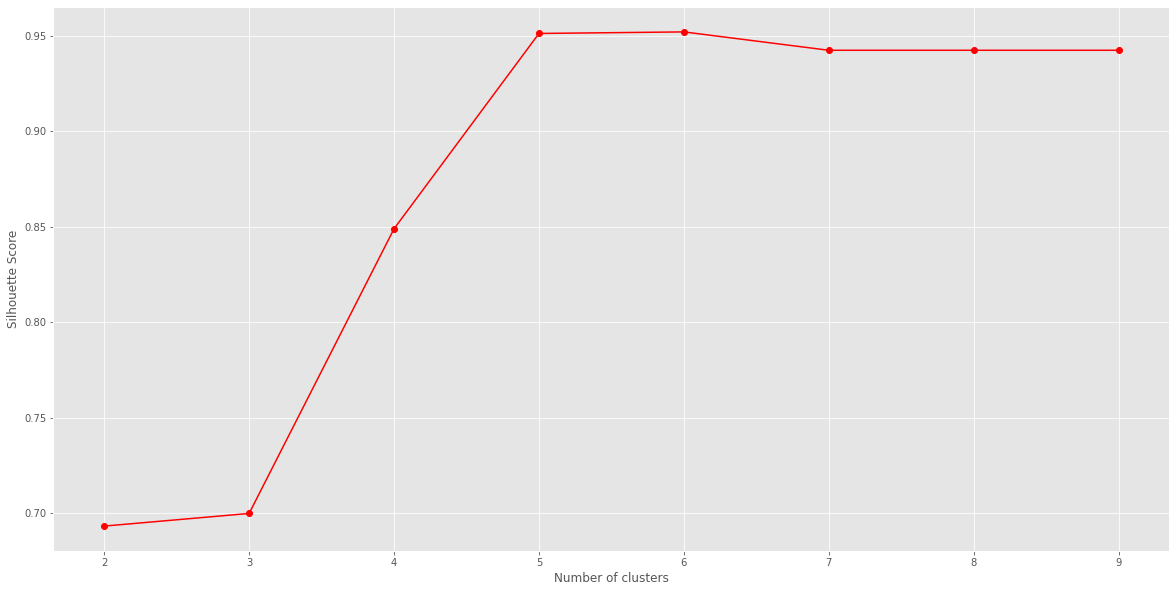

In [41]:
brgh_grouped_clustering = thai.drop('Area', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(brgh_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(brgh_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

As seen from the above line plot, the best number of clusters having the highest silhouette score is 6. So, lets consider the number of clusters as 6.

In [ ]:
kclusters = 4

brgh_grouped_clustering = thai.drop('Area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brgh_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 3, 1, 3, 2, 1, 3, 0, 2], dtype=int32)

In [42]:
kclusters = 6

#brgh_grouped_clustering = thai.drop('Area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brgh_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 0, 0, 2, 4, 1, 2, 4, 5, 1], dtype=int32)

In [43]:
brgh_venues_sorted.insert(0, 'ClusterLab', kmeans.labels_)
Area_merged = pd.merge(dfx,brgh_venues_sorted, on='Area')

In [44]:
Area_merged.head()

,Region,Area,latitude,longitude,ClusterLab,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Central,Bishan,1.350986,103.848255,0,Chinese Restaurant,Park,Food Court,Supermarket,Bakery
1,Central,Bukit Merah,4.561694,101.024037,1,Chinese Restaurant,Malay Restaurant,Convenience Store,Seafood Restaurant,Asian Restaurant
2,Central,Bukit Timah,1.354690,103.776372,4,Italian Restaurant,Chinese Restaurant,Bakery,Park,Nature Preserve
3,Central,Downtown Core,1.287475,103.856033,2,Hotel,Waterfront,Event Space,Cocktail Bar,Italian Restaurant
4,Central,Geylang,1.318186,103.887056,4,Hotel,Coffee Shop,Café,Ice Cream Shop,Chinese Restaurant


In [45]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors
print('matplotlib imported...')
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Area_merged['latitude'], Area_merged['longitude'], Area_merged['Area'], Area_merged['ClusterLab']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

matplotlib imported...


In [61]:
thai["Cluster Labels"] = kmeans.labels_
thai.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Area,Thai Restaurant,Cluster Labels
0,Ang Mo Kio,0.06,3
1,Bedok,0.03,0
2,Bishan,0.03,0
3,Boon Lay,0.01,2
4,Bukit Batok,0.02,4


In [68]:
thai['Cluster Labels'].value_counts()

1    18
2    16
0     8
4     7
3     2
5     1
Name: Cluster Labels, dtype: int64

Analyze the first cluster

In [48]:
cluster1=Area_merged.loc[Area_merged['ClusterLab'] == 0, Area_merged.columns[[0] + list(range(4, Area_merged.shape[1]))]]
cluster1.head()

,Region,ClusterLab,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Central,0,Chinese Restaurant,Park,Food Court,Supermarket,Bakery
22,East,0,Chinese Restaurant,Coffee Shop,Dessert Shop,Asian Restaurant,Beach
25,East,0,Hotel,Coffee Shop,Café,Supermarket,Ice Cream Shop
26,East,0,Coffee Shop,Chinese Restaurant,Bakery,Dessert Shop,Park
30,North,0,Park,Chinese Restaurant,Seafood Restaurant,Coffee Shop,Café


In [50]:
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']))

print(venues1.value_counts().head(10))

Coffee Shop           7
Park                  5
Chinese Restaurant    5
Supermarket           4
Café                  3
Dessert Shop          2
Asian Restaurant      2
Bakery                2
Exhibit               1
Food Court            1
dtype: int64


In [52]:
cluster2=Area_merged.loc[Area_merged['ClusterLab'] == 1, Area_merged.columns[[0] + list(range(4, Area_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']))

print(venues2.value_counts().head(10))

Park                  5
Coffee Shop           5
Hotel                 5
Farm                  4
Chinese Restaurant    3
Boat or Ferry         3
Seafood Restaurant    3
Harbor / Marina       3
Trail                 2
Grocery Store         2
dtype: int64


In [53]:
cluster3=Area_merged.loc[Area_merged['ClusterLab'] == 2, Area_merged.columns[[0] + list(range(4, Area_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']))

print(venues3.value_counts().head(10))

Hotel                  8
Park                   8
Japanese Restaurant    6
Chinese Restaurant     6
Waterfront             5
Coffee Shop            5
Food Court             4
Italian Restaurant     4
Event Space            4
Indian Restaurant      4
dtype: int64


In [54]:
cluster4=Area_merged.loc[Area_merged['ClusterLab'] == 3, Area_merged.columns[[0] + list(range(4, Area_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']))

print(venues4.value_counts().head(10))

Coffee Shop           2
Thai Restaurant       2
Park                  2
Chinese Restaurant    2
Café                  1
Indian Restaurant     1
dtype: int64


In [60]:
cluster5=Area_merged.loc[Area_merged['ClusterLab'] == 4, Area_merged.columns[[0] + list(range(4, Area_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']))

print(venues5.value_counts().head(10))

Chinese Restaurant     5
Coffee Shop            4
Ice Cream Shop         3
Italian Restaurant     3
Japanese Restaurant    2
Hotel                  2
Park                   2
Café                   2
Bakery                 2
Indian Restaurant      1
dtype: int64


**My Recommendation For Opening a New Thai Resturant in Singapore **

While cluster 1 and cluster 2 have the maximum number of resturants, cluster 4 and cluster 3 have Thai resturants among their most frequent locations. Cluster 5 has the lowest number of resturants. So areas such as Holland park which have the lowest number of Thai resturants can be considered as  vaiable area for opening a Thai resturant owing to lower competition. Planning areas such as Changi and Serangoon road which have a high concentration of Thai resturants can have a higher competition for a newer Thai estabilishments

**Other Features That Can Be Extracted From the Dataset to faciliate a more detailed analysis**
The other features that can be extracted from the dataset include: (a) the top 10 venues in a planning area (b) Details of other Asian cuisine resturants which could pose a competition to a new Thai resturant (c) Details of subway and public transport to help assess the the accessibility of the locations (d) Reviews and pricing details of other Thai resturants in the vicinity (d) Sub-zone information